<a href="https://colab.research.google.com/github/drewwint/neuromatch-2021/blob/main/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Convolutional Neural Networks
**Week 2, Day 1: Deep Learning**

**By Neuromatch Academy**

**Content creators**: Jorge A. Menendez, Carsen Stringer 

**Content reviewers**: Roozbeh Farhoodi, Ella Batty, Kshitij Dwivedi, Spiros Chavlis, Michael Waskom





---
# Tutorial Objectives

In this short tutorial, we'll go through an introduction to 2D convolutions and apply a convolutional network to an image to prepare for creating normative models in tutorial 3.

In this tutorial, we will 
* Understand the basics of 2D convolution
* Build a convolutional layer using PyTorch
* Visualize and analyze its outputs
* (Bonus) Build an encoding model from images to neural responses

---
# Setup


In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
#@title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned6_split.npz"
url = "https://osf.io/p3aeb/download"
expected_md5 = "b3f7245c6221234a676b71a1f43c3bb5"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
#@title Plotting Functions

def plot_tuning(ax, stimuli, respi_train, respi_test, neuron_index, linewidth=2):
  """Plot the tuning curve of a neuron"""

  ax.plot(stimuli, respi_train, 'y', linewidth=linewidth)  # plot its responses as a function of stimulus orientation
  ax.plot(stimuli, respi_test, 'm', linewidth=linewidth)  # plot its responses as a function of stimulus orientation
  ax.set_title('neuron %i' % neuron_index)
  ax.set_xlabel('stimulus orientation ($^o$)')
  ax.set_ylabel('neural response')
  ax.set_xticks(np.linspace(0, 360, 5))
  ax.set_ylim([-0.5, 2.4])


def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img+0.5, cmap=mpl.cm.binary)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)


def plot_example_activations(stimuli, act, channels=[0]):
  """ plot activations act and corresponding stimulus
  Args:
        stimuli: stimulus input to convolutional layer (n x h x w) or (h x w)
        act: activations of convolutional layer (n_bins x conv_channels x n_bins)
        channels: which conv channels to plot
  """
  if stimuli.ndim>2:
    n_stimuli = stimuli.shape[0]
  else:
    stimuli = stimuli.unsqueeze(0)
    n_stimuli = 1

  fig, axs = plt.subplots(n_stimuli,1+len(channels),figsize=(12,12))

  # plot stimulus
  for i in range(n_stimuli):
    show_stimulus(stimuli[i].squeeze(), ax=axs[i, 0])
    axs[i, 0].set_title('stimulus')

    # plot example activations
    for k, (channel, ax) in enumerate(zip(channels, axs[i][1:])):
      img=ax.imshow(act[i,channel], vmin=-6, vmax=6, cmap='bwr')
      ax.set_xlabel('x-pos')
      ax.set_ylabel('y-pos')
      ax.set_title('channel %d'%channel)
  ax = fig.add_axes([1.05,0.8,0.01,0.1])
  plt.colorbar(img, cax=ax)
  ax.set_title('activation\n strength')


def plot_weights(weights, channels=[0], colorbar=True):
  """ plot convolutional channel weights
  Args:
        weights: weights of convolutional filters (conv_channels x K x K)
        channels: which conv channels to plot
  """
  wmax = torch.abs(weights).max()
  fig, axs = plt.subplots(1,len(channels), figsize=(12,2.5))
  for i, channel in enumerate(channels):
    im = axs[i].imshow(weights[channel,0], vmin=-wmax, vmax=wmax, cmap='bwr')
    axs[i].set_title('channel %d'%channel)

  if colorbar:
    ax = fig.add_axes([1, 0.1, 0.05, 0.8])
    plt.colorbar(im, ax=ax)
    ax.axis('off')


def plot_prediction(ax, y_pred, y_train, y_test):
  """ plot prediction of neural response + test neural response """
  ax.plot(y_train, 'y', linewidth=1)
  ax.plot(y_test,color='m')
  ax.plot(y_pred, 'g', linewidth=3)
  ax.set_xlabel('stimulus bin')
  ax.set_ylabel('response')


def plot_training_curves(train_loss, test_loss):
  """
  Args:
    train_loss (list): training error over iterations
    test_loss (list): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  f, ax = plt.subplots()
  # Plot the training loss over iterations of GD
  ax.plot(train_loss)
  # Plot the testing loss over iterations of GD
  ax.plot(test_loss, '.', markersize=10)
  ax.legend(['train loss', 'test loss'])
  ax.set(xlabel="Gradient descent iteration", ylabel="Mean squared error")

In [5]:
#@title Helper Functions

def load_data_split(data_name=fname):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. The repsonses were split into train and
  test and then each set were averaged in bins of 6 degrees.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  It will hold out some of the trials when averaging to allow us to have test
  tuning curves.

  Args:
    data_name (str): filename to load

  Returns:
    resp_train (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    resp_test (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp_train = data['resp_train']
  resp_test = data['resp_test']
  stimuli = data['stimuli']

  # Return as torch.Tensor
  resp_train_tensor = torch.tensor(resp_train, dtype=torch.float32)
  resp_test_tensor = torch.tensor(resp_test, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32)

  return resp_train_tensor, resp_test_tensor, stimuli_tensor


def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  gratings -= 0.5

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)


def filters(K=7):
  """ make example filters, some center-surround and gabors
  Returns:
      filters: 6 x K x K
  """
  grid = np.linspace(-K/2, K/2, K).astype(np.float32)
  xx,yy = np.meshgrid(grid, grid, indexing='ij')

  # create center-surround filters
  sigma = 1.1
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
  wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
  center_surround = gaussian - 0.5 * wide_gaussian

  # create gabor filters
  thetas = np.array([0, 45, 90, 135]) * np.pi/180
  gabors = np.zeros((len(thetas), K, K), np.float32)
  lam = 10
  phi = np.pi/2
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
  for i,theta in enumerate(thetas):
    x = xx*np.cos(theta) + yy*np.sin(theta)
    gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

  filters = np.concatenate((center_surround[np.newaxis,:,:],
                            -1*center_surround[np.newaxis,:,:],
                            gabors),
                           axis=0)
  filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
  # convert to torch
  filters = torch.from_numpy(filters)
  # add channel axis
  filters = filters.unsqueeze(1)

  return filters


def regularized_MSE_loss(output, target, weights=None, L2_penalty=0, L1_penalty=0):
  """loss function for MSE

  Args:
    output (torch.Tensor): output of network
    target (torch.Tensor): neural response network is trying to predict
    weights (torch.Tensor): fully-connected layer weights of network (net.out_layer.weight)
    L2_penalty : scaling factor of sum of squared weights
    L1_penalty : scalaing factor for sum of absolute weights

  Returns:
    (torch.Tensor) mean-squared error with L1 and L2 penalties added

  """

  loss_fn = nn.MSELoss()
  loss = loss_fn(output, target)

  if weights is not None:
    L2 = L2_penalty * torch.square(weights).sum()
    L1 = L1_penalty * torch.abs(weights).sum()
    loss += L1 + L2

  return loss

def train(net, custom_loss, train_data, train_labels,
          test_data=None, test_labels=None,
          learning_rate=10, n_iter=500, L2_penalty=0., L1_penalty=0.):
  """Run gradient descent for network without batches

  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    custom_loss: loss function for network
    train_data: training data (n_train x input features)
    train_labels: training labels (n_train x output features)
    test_data: test data (n_train x input features)
    test_labels: test labels (n_train x output features)
    learning_rate (float): learning rate for gradient descent
    n_epochs (int): number of epochs to run gradient descent
    L2_penalty (float): magnitude of L2 penalty
    L1_penalty (float): magnitude of L1 penalty

  Returns:
    train_loss: training loss across iterations
    test_loss: testing loss across iterations

  """
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) # Initialize PyTorch SGD optimizer
  train_loss = np.nan * np.zeros(n_iter)  # Placeholder for train loss
  test_loss = np.nan * np.zeros(n_iter)  # Placeholder for test loss

  # Loop over epochs
  for i in range(n_iter):
    if n_iter < 10:
      for param_group in self.optimizer.param_groups:
        param_group['lr'] = np.linspace(0, learning_rate, 10)[n_iter]
    y_pred = net(train_data) # Forward pass: compute predicted y by passing train_data to the model.

    if L2_penalty>0 or L1_penalty>0:
      weights = net.out_layer.weight
      loss = custom_loss(y_pred, train_labels, weights, L2_penalty, L1_penalty)
    else:
      loss = custom_loss(y_pred, train_labels)

    ### Update parameters
    optimizer.zero_grad() # zero out gradients
    loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step() # step parameters in gradient direction
    train_loss[i] = loss.item()  # .item() transforms the tensor to a scalar and does .detach() for us

    # Track progress
    if (i+1) % (n_iter // 10) == 0 or i==0:
      if test_data is not None and test_labels is not None:
        y_pred = net(test_data)
        if L2_penalty>0 or L1_penalty>0:
          loss = custom_loss(y_pred, test_labels, weights, L2_penalty, L1_penalty)
        else:
          loss = custom_loss(y_pred, test_labels)
        test_loss[i] = loss.item()
        print(f'iteration {i+1}/{n_iter} | train loss: {train_loss[i]:.4f} | test loss: {test_loss[i]:.4f}')
      else:
        print(f'iteration {i+1}/{n_iter} | train loss: {train_loss[i]:.4f}')

  return train_loss, test_loss

---
# Section 1: Introduction to 2D convolutions



## Section 1.1: What is a 2D convolution?

A 2D convolution is an integral of the product of a filter $f$ and an input image $I$ computed at various positions as the filter is slid across the input. The output of the convolution operation at position $(x,y)$ can be written as follows, where the filter $f$ is size $(K,K)$:
\begin{equation}
C(x,y) = \sum_{k_x=-K/2}^{K/2} \sum_{k_y=-K/2}^{K/2} f(k_x,k_y) I(x+k_x,y+k_y)
\end{equation}
This **convolutional filter** is often called a **kernel**.

Here is an illustration of a 2D convolution from this [article](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-convolution-neural-networks-e3f054dd5daa):

In [6]:
#@title
#@markdown Execute this cell to view convolution gif

from IPython.display import Image
Image(url='https://miro.medium.com/max/700/1*5BwZUqAqFFP5f3wKYQ6wJg.gif')

## Section 1.2: 2D convolutions in deep learning


In [7]:
# @title Video 1: 2D Convolutions
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="igLkHuuJurE", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


In the [intro](https://www.youtube.com/watch?v=IZvcy0Myb3M) you learned about convolutional networks for computer vision tasks and applications to neuroscience. Object recognition was essentially an unsolved problem in machine learning until the [advent](https://en.wikipedia.org/wiki/AlexNet) of techniques for effectively training *deep* convolutional neural networks. See Bonus Section 1 for more information on why we use CNNs to model the visual system.

Convolutional neural networks consist of 2D convolutional layers, RELU non-linearities, 2D pooling layers, and at the output, a fully connected layer. We will see an example network with all these components in tutorial 3. 

A 2D convolutional layer consists of multiple channels. Each **channel** is a 2D convolutional filter applied to the input resulting in several units, where the number of units depends on the *stride* you set. In most applications, especially with small filter sizes, a stride of 1 is used.

(*Technical note*: if filter size *K* is odd and you set the *pad=K//2* and *stride=1* (as is shown below), you get a **channel** of units that is the same size as the input.)

In [8]:
#@title
#@markdown Execute this cell to view convolution gif

from IPython.display import Image
Image(url='https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif')

## Section 1.3: 2D convolutions in Pytorch

In Tutorial 1, fully connected linear layers were used to decode stimuli from neural activity. Convolutional layers are different from their fully connected counterparts in two ways:
  * In a fully connected layer, each unit computes a weighted sum over all the input units. In a convolutional layer, on the other hand, each unit computes a weighted sum over only a small patch of the input, referred to as the unit's **receptive field**. When the input is an image, the receptive field can be thought of as a local patch of pixels.
  * In a fully connected layer, each unit uses its own independent set of weights to compute the weighted sum. In a convolutional layer, all the units (within the same channel) **share the same weights**. This set of shared weights is called the **convolutional filter or kernel**. The result of this computation is a convolution, where each unit has computed the same weighted sum over a different part of the input. This reduces the number of parameters in the network substantially.

<p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/weight-sharing.png?raw=true" width="700" />
</p>


We will compute the difference in the number of weights for a fully connected layer versus a convolutional layer in the Think exercise below.

First, let's visualize the stimuli in the dataset from tutorial 1. During the neural recordings from [Stringer et al 2019](https://www.biorxiv.org/content/10.1101/679324v2.abstract), mice were presented oriented gratings:

stimulus size: 48 x 64


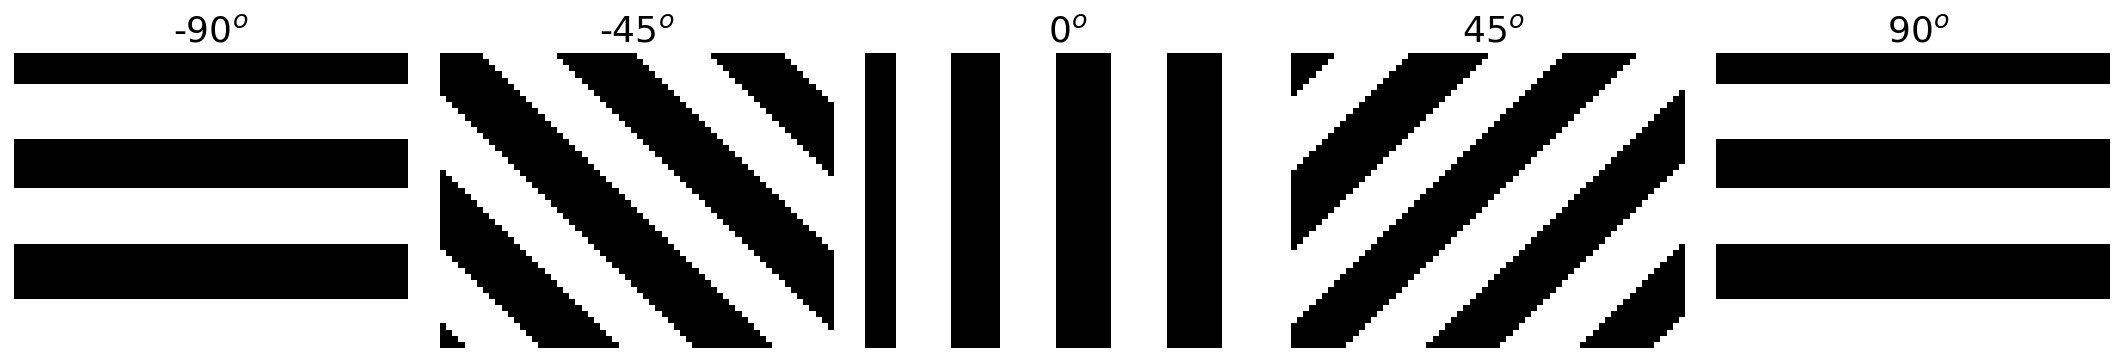

In [9]:
#@title
#@markdown Execute this cell to plot example stimuli

orientations = np.linspace(-90, 90, 5)

h = 3
n_col = len(orientations)
fig, axs = plt.subplots(1, n_col, figsize=(h * n_col, h))

h, w  = grating(0).shape  # height and width of stimulus
print('stimulus size: %i x %i' % (h, w))

for i, ori in enumerate(orientations):
  stimulus = grating(ori)
  axs[i].set_title(f'{ori: .0f}$^o$')
  show_stimulus(stimulus, axs[i])

Now let's implement 2D convolutional operations. We will use mutliple convolutional channels and implement this operation efficiently using pytorch. A *layer* of convolutional channels can be implemented with one line of code using the PyTorch class `nn.Conv2d()`, which requires the following arguments for initialization (see full documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)):
  * $C^{in}$: the number of input channels
  * $C^{out}$: the number of output channels (number of different convolutional filters)
  * $K$: the size of the $C^{out}$ different convolutional filters
  
When you run the network, you can input a stimulus of arbitrary size $(H^{in}, W^{in})$, but it needs to be shaped as a 4D input $(N, C^{in}, H^{in}, W^{in})$, where $N$ is the number of images. In our case, $C^{in}=1$ because there is only one color channel (our images are grayscale, but often $C^{in}=3$ in image processing).

In [10]:
class ConvolutionalLayer(nn.Module):
  """Deep network with one convolutional layer
     Attributes: conv (nn.Conv2d): convolutional layer
  """
  def __init__(self, c_in=1, c_out=6, K=7, filters=None):
    """Initialize layer

    Args:
        c_in: number of input stimulus channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter
        filters: (optional) initialize the convolutional weights

    """
    super().__init__()
    self.conv = nn.Conv2d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)
    if filters is not None:
      self.conv.weight = nn.Parameter(filters)
      self.conv.bias = nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

  def forward(self, s):
    """Run stimulus through convolutional layer

    Args:
        s (torch.Tensor): n_stimuli x h x w tensor with stimuli

    Returns:
        (torch.Tensor): n_stimuli x c_out x w x h tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1) # add channel dimension
    a = self.conv(s)  # output of convolutional layer

    return a

### Coding Exercise 1.2: 2D convolution in pytorch 

We will now run the convolutional layer on our stimulus. We will use gratings stimuli made using the function `grating`, which returns a stimulus which is 48 x 64. 

Reminder, `nn.Conv2d` takes in a tensor of size $(N, C^{in}, H^{in}, W^{in}$) where $N$ is the number of stimuli, $C^{in}$ is the number of input channels, and $(H^{in}, W^{in})$ is the size of the stimulus. We will need to add these first two dimensions to our stimulus, then input it to the convolutional layer.

We will plot the outputs of the convolution. `convout` is a tensor of size $(N, C^{out}, H^{in}, W^{in})$ where $N$ is the number of examples and $C^{out}$ are the number of convolutional channels. It is the same size as the input because we used a stride of 1 and padding that is half the kernel size.


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


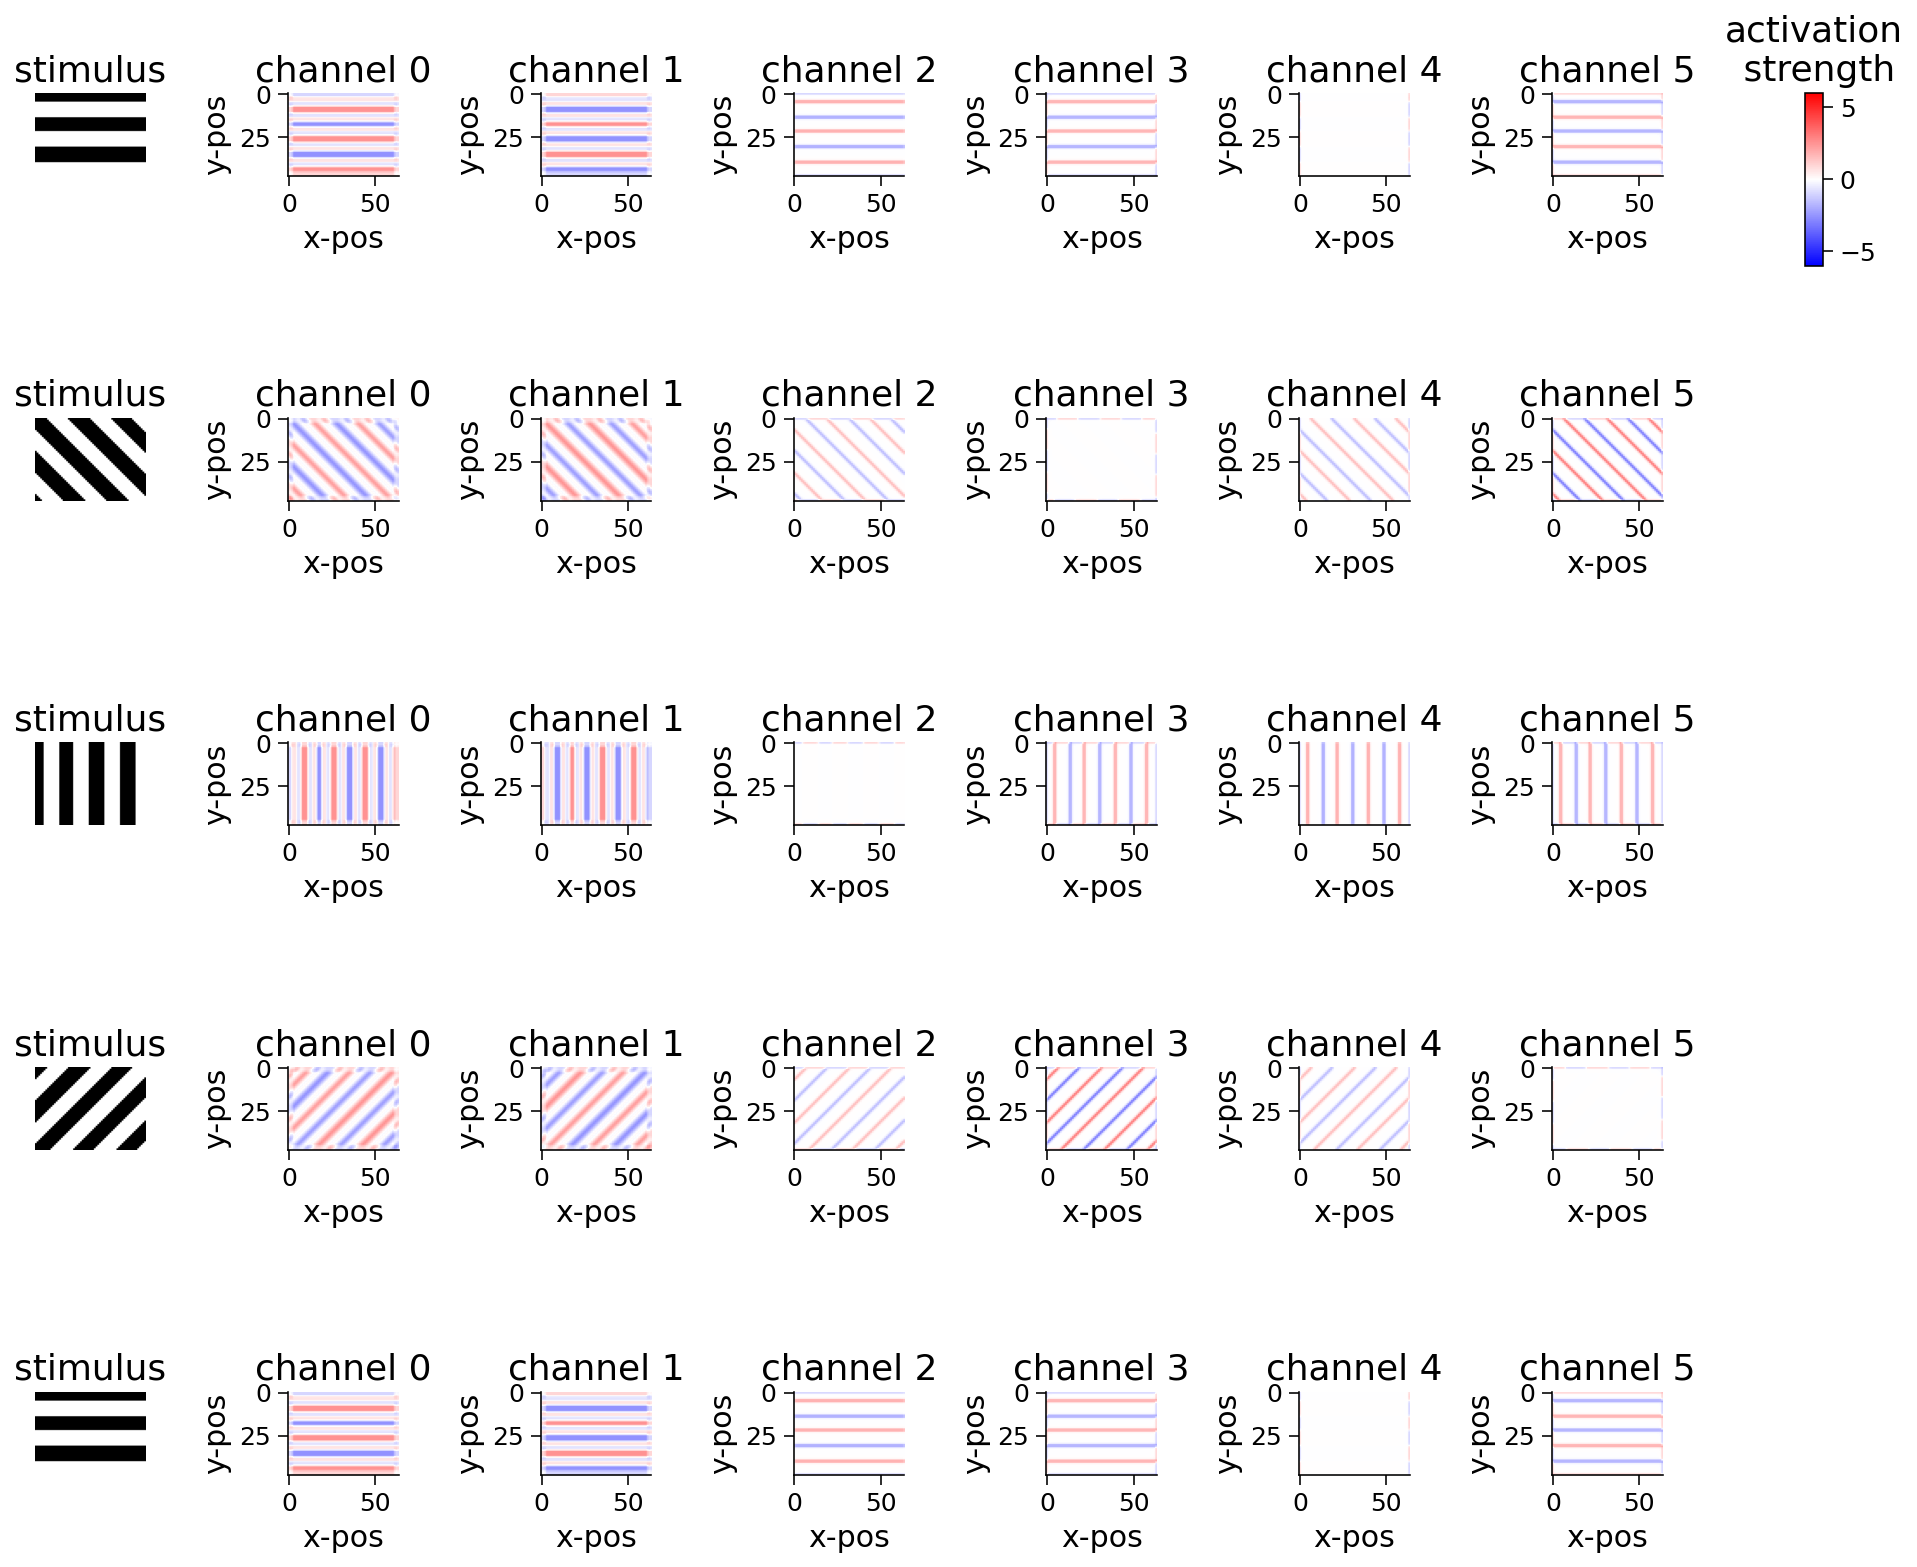

In [14]:
# Convolution layer parameters
K = 7 # filter size
conv_channels = 6 # how many convolutional channels to have in our layer
convout = np.zeros(0) # assign convolutional activations to convout

################################################################################
## TODO for students: create convolutional layer in pytorch
# Complete and uncomment
################################################################################

### Initialize conv layer and add weights from function filters
# you need to specify :
# * the number of input channels c_in
# * the number of output channels c_out
# * the filter size K
convLayer = ConvolutionalLayer(c_in=1, c_out=conv_channels, K=K,
                               filters=filters(K))

### Create stimuli (H_in, W_in)
stimuli = torch.zeros((len(orientations), 48, 64), dtype=torch.float32)
orientations = [-90, -45, 0, 45, 90]
for i,ori in enumerate(orientations):
  stimuli[i] = grating(ori)

convout = convLayer(stimuli)
convout = convout.detach() # detach gradients

plot_example_activations(stimuli, convout, channels=np.arange(0, conv_channels))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_DeepLearning/solutions/W2D1_Tutorial2_Solution_3f2bd25a.py)

*Example output:*

<img alt='Solution hint' align='left' width=948 height=799 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_DeepLearning/static/W2D1_Tutorial2_Solution_3f2bd25a_1.png>



#### Think! 2.3: Output and weight shapes in a convolutional layer

Let's think about the shape of the weights and outputs of `convLayer`:
  - How many convolutional activations are there in each channel, and why is it this size?
  - How many weights does `convLayer` have? 
  - How many weights would it have if it were a fully connected layer?

Additionally, let's think about why the activations look the way they do. It seems like for all channels the activations are only non-zero for edges of the gratings (where the grating goes from white-to-black and from black-to-white).
  -  Channel 0 and 1 seem to respond to every edge regardless of the orientation, but their signs are different. What type of filter might produce these types of responses?
  - Channels 2-5 seem to respond differently depending on the orientation of the stimulus. What type of filter might produce these types of responses?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_DeepLearning/solutions/W2D1_Tutorial2_Solution_455be0bb.py)



#### answer
1. There are H * W activations in each channel because the stride in the
convolutional layer is set to 1, and the padding is set to K//2.
2. The convLayer has K * K * C_out weights and C_out bias terms.
3. A fully connected layer would have (H * W) * C_out weights and C_out bias terms.
4. A center-surround filter will respond to a change in luminance (black-to-white
or white-to-black) regardless of orientation.
5. A gabor filter of different orientations will respond this way. See the
exercise below for more explanation.

Please see Bonus Section 2 to visualize the convolutional filter weights. See Bonus Section 3 to use CNNs as encoding models of neurons (by fitting directly to neural responses).

---
# Summary

In this notebook, we built a 2D convolutional layer which is meant to represent the responses of neurons in mouse visual cortex, or the responses of neurons 
which are inputs to mouse visual cortex.

In Tutorial 3, we will add to this 2D convolutional layer a fully-connected layer and train this model to predict whether an orientation is left or right. We will see if the convolutional filters it learns are similar to mouse visual cortex.

---
# Bonus

## Bonus Section 1: Why CNN's?

CNN models are particularly [well-suited](https://www.nature.com/articles/nn.4244) to modeling the visual system for a number of reasons:

1. **Distributed computation**: like any other neural network, CNN's use distributed representations to compute -- much like the brain seems to do. Such models, therefore, provide us with a vocabulary with which to talk and think about such distributed representations. Because we know the exact function the model is built to perform (e.g. orientation discrimination), we can analyze its internal representations with respect to this function and begin to interpret why the representations look the way they do. Most importantly, we can then use these insights to analyze the structure of neural representations observed in recorded population activity. We can qualitatively and quantitatively compare the representations we see in the model and in a given population of real neurons to hopefully tease out the computations it performs.

2. **Hierarchical architecture**: like in any other deep learning architecture, each layer of a deep CNN comprises a non-linear transformation of the previous layer. Thus, there is a natural hierarchy whereby layers closer to the network output represent increasingly more abstract information about the input image. For example, in a network trained to do object recognition, the early layers might represent information about edges in the image, whereas later layers closer to the output might represent various object categories. This resembles the [hierarchical structure of the visual system](https://pubmed.ncbi.nlm.nih.gov/1822724/), where [lower-level areas](https://www.jneurosci.org/content/25/46/10577.short) (e.g. retina, V1) represent visual features of the sensory input and [higher-level areas](https://www.sciencedirect.com/science/article/pii/S089662731200092X) (e.g. V4, IT) represent properties of objects in the visual scene. We can then naturally use a single CNN to model multiple visual areas, using early CNN layers to model lower-level visual areas and late CNN layers to model higher-level visual areas.
  
  Relative to fully connected networks, CNN's, in fact, have further hierarchical structure built-in through the max pooling layers. Recall that each output of a convolution + pooling block is the result of processing a local patch of the inputs to that block. If we stack such blocks in a sequence, then the outputs of each block will be sensitive to increasingly larger regions of the initial raw input to the network: an output from the first block is sensitive to a single patch of these inputs, corresponding to its "receptive field"; an output from the second block is sensitive to a patch of outputs from the first block, which together are sensitive to a larger patch of raw inputs comprising the union of their receptive fields. Receptive fields thus get larger for deeper layers (see [here](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) for a nice visual depiction of this). This resembles primate visual systems, where neurons in higher-level visual areas respond to stimuli in wider regions of the visual field than neurons in lower-level visual areas.

3. **Convolutional layers**: through the weight sharing constraint, the outputs of each channel of a convolutional layer process different parts of the input image in exactly the same way. This architectural constraint effectively builds into the network the assumption that objects in the world typically look the same regardless of where they are in space. This is useful for modeling the visual system for two (largely separate) reasons:
  * Firstly, this assumption is generally valid in mammalian visual systems, since mammals tend to view the same object from many perspectives. Two neurons at a similar hierarchy in the visual system with different receptive fields could thus end up receiving statistically similar synaptic inputs, so that the synaptic weights developed over time may end up being similar as well.
  * Secondly, this architecture significantly improves object recognition ability. Object recognition was essentially an unsolved problem in machine learning until the [advent](https://en.wikipedia.org/wiki/AlexNet) of techniques for effectively training *deep* convolutional neural networks. Fully connected networks on their own can't achieve object recognition abilities anywhere close to human levels, making them bad models of human object recognition. Indeed, it is generally the case that [the better a neural network model is at object recognition, the closer the match between its representations and those observed in the brain](https://www.pnas.org/content/111/23/8619.short). That said, it is worth noting that our much simpler orientation discrimination task (in Tutorial 3) can be solved by relatively simple networks.

---
## Bonus Section 2: Understanding activations from weight

### Bonus Coding Exercise 2: Visualizing convolutional filter weights

Why do the activations look the way they do? Let's look at the weights (`convLayer.conv.weight`) of the convolutional filters and try to interpret them.

In [ ]:
################################################################################
## TODO for students: create convolutional layer in pytorch
# Complete and uncomment
################################################################################

# get weights of conv layer in convLayer
# weights = ...
# print(weights.shape) # can you identify what each of the dimensions are?

# plot_weights(weights, channels=np.arange(0, conv_channels))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_DeepLearning/solutions/W2D1_Tutorial2_Solution_a1ae60f7.py)

*Example output:*

<img alt='Solution hint' align='left' width=939 height=158 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_DeepLearning/static/W2D1_Tutorial2_Solution_a1ae60f7_2.png>



In the function `filters` we premade center-surround filters and Gabor filters of various orientations. [Gabor filters](https://en.wikipedia.org/wiki/Gabor_filter) have a positive region next to a negative region and the orientation of these regions of the filter determine the orientation of edges to which they respond. 

In visual cortex, Hubel and Wiesel discovered simple cells, which would correspond to a unit in the channels 2-5 above with Gabor filters. There are also some neurons with activity that resembles center-surround filters, which would correspond to the first two convolutional channels above.

There were additional cells discovered by Hubel and Wiesel - complex cells - that respond to an oriented grating regardless of where the bars are exactly (note that the responses we see are specific to where the bars are). These cells therefore have some level of translation invariance. This is something that convolutional neural networks try to replicate -- e.g. a grating is still oriented horizontal even if it moves slightly, and a cat is still a cat even if it's in a different position in the image.

#### Think!
  - How might you create a complex cell and have responses that are translation invariant?
  - How might you create a cell that responds to multiple orientations?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_DeepLearning/solutions/W2D1_Tutorial2_Solution_13ec7f73.py)



---
## Bonus Section 3: Neural encoding model



In [ ]:
# @title Video 2: Convolutional Encoding Model
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="TCAQYIoqcgA", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


In neuroscience, we often want to understand how the brain represents external stimuli. One approach to discovering these representations is to build an encoding model that takes as input the external stimuli (in this case grating stimuli) and outputs the neural responses. 

Because visual cortex is often thought to be a convolutional network where the same filters are combined across the visual field, we will use a model with a convolutional layer. We learned how to build a convolutional layer in the previous section. We will add to this convolutional layer a fully connected layer from the output of the convolutions to the neurons. We will then visualize the weights of this fully connected layer.

### Bonus Section 3.1: Neural tuning curves

In the next cell, we plot the turning curves of a random subset of neurons. We have binned the stimuli orientations more than in Tutorial 1. We create the gratings images as above for the 60 orientations below, and save them to a variable `grating_stimuli`.

Rerun the cell to look at different example neurons and observe the diversity of tuning curves in the population. How can we fit these neural responses with an encoding model?

In [ ]:
#@title
#@markdown Execute this cell to load data, create stimuli, and plot neural tuning curves

### Load data and bin at 8 degrees
# responses are split into test and train
resp_train, resp_test, stimuli = load_data_split()
n_stimuli, n_neurons = resp_train.shape
print('resp_train contains averaged responses of %i neurons to %i binned stimuli' % (n_neurons, n_stimuli))
#print(resp_train.shape)

# also make stimuli into images
orientations = np.linspace(0, 360, 61)[:-1] - 180
grating_stimuli = np.zeros((60, 12, 16), np.float32)
for i, ori in enumerate(orientations):
  grating_stimuli[i] = grating(ori, res=0.025)#[18:30, 24:40]

grating_stimuli = torch.from_numpy(grating_stimuli)
print('grating_stimuli contains 60 stimuli of size 12 x 16')

# Visualize tuning curves
fig, axs = plt.subplots(3, 5, figsize=(15,7))
for k, ax in enumerate(axs.flatten()):
  neuron_index = np.random.choice(n_neurons)  # pick random neuron
  plot_tuning(ax, stimuli, resp_train[:, neuron_index], resp_test[:, neuron_index], neuron_index, linewidth=2)
  if k==0:
    ax.text(1.0, 0.9, 'train', color='y', transform=ax.transAxes)
    ax.text(1.0, 0.65, 'test', color='m', transform=ax.transAxes)
fig.tight_layout()
plt.show()

### Bonus Section 3.2: Adding a fully-connected layer to create encoding model

We will build a torch model like above with a convolutional layer. Additionally, we will add a fully connected linear layer from the convolutional units to the neurons. We will use 6 convolutional channels ($C^{out}$) and a kernel size ($K$) of 7 with a stride of 1 and padding of $K/2$ (same as above). The stimulus is size `(12, 16)`. Then the convolutional unit activations will go through a linear layer to be transformed into neural responses.



#### Think! 3.2: Number of unis and weights

* How many units will the convolutional layer have?
* How many weights will the fully connected linear layer from convolutional units to neurons have?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_DeepLearning/solutions/W2D1_Tutorial2_Solution_1240d23d.py)



#### Bonus Coding Exercise 3.2: Add linear layer

Remember in Tutorial 1 we used linear layers. Use your knowledge from Tutorial 1 to add a linear layer to the model we created above.

In [ ]:
class ConvFC(nn.Module):
  """Deep network with one convolutional layer + one fully connected layer

  Attributes:
    conv (nn.Conv1d): convolutional layer
    dims (tuple): shape of convolutional layer output
    out_layer (nn.Linear): linear layer

  """

  def __init__(self, n_neurons, c_in=1, c_out=6, K=7, b=12*16,
               filters=None):
    """ initialize layer
    Args:
        c_in: number of input stimulus channels
        c_out: number of convolutional channels
        K: size of each convolutional filter
        h: number of stimulus bins, n_bins
    """
    super().__init__()
    self.conv = nn.Conv2d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)
    self.dims = (c_out, b)  # dimensions of conv layer output
    M = np.prod(self.dims) # number of hidden units

    ################################################################################
    ## TO DO for students: add fully connected layer to network (self.out_layer)
    # Fill out function and remove
    raise NotImplementedError("Student exercise: add fully connected layer to initialize network")
    ################################################################################
    self.out_layer = nn.Linear(M, ...)

    # initialize weights
    if filters is not None:
      self.conv.weight = nn.Parameter(filters)
      self.conv.bias = nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

    nn.init.normal_(self.out_layer.weight, std=0.01) # initialize weights to be small

  def forward(self, s):
    """ Predict neural responses to stimuli s

    Args:
        s (torch.Tensor): p x L tensor with stimuli

    Returns:
        torch.Tensor: p x N tensor with convolutional layer unit activations.

    """
    s = s.unsqueeze(1)  # p x 1 x W x H, add a singleton dimension for the single channel
    a = self.conv(s)  # output of convolutional layer
    a = a.view(-1, np.prod(self.dims))  # flatten each convolutional layer output into a vector

    ################################################################################
    ## TO DO for students: add fully connected layer to forward pass of network (self.out_layer)
    # Fill out function and remove
    raise NotImplementedError("Student exercise: add fully connected layer to network")
    ################################################################################
    y = ...

    return y


device = torch.device('cpu')

# (Optional) To speed up processing, go to "Runtime" menu and "Change runtime"
# and select GPU processing, then uncomment line below, otherwise runtime will
# be ~ 2 minutes
# device = torch.device('cuda')

# Initialize network
n_neurons = resp_train.shape[1]
K = 7
# we will initialize with the same filters as above
net = ConvFC(n_neurons, filters=filters(K))
net = net.to(device)

# Run GD on training set data
# ** this time we are also providing the test data to estimate the test loss
train_loss, test_loss = train(net, regularized_MSE_loss,
                              train_data=grating_stimuli.to(device), train_labels=resp_train.to(device),
                              test_data=grating_stimuli.to(device), test_labels=resp_test.to(device),
                              n_iter=200, learning_rate=2,
                              L2_penalty=5e-4, L1_penalty=1e-6)

# Plot the training loss over iterations of GD
plot_training_curves(train_loss, test_loss)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_DeepLearning/solutions/W2D1_Tutorial2_Solution_490d72a9.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=413 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_DeepLearning/static/W2D1_Tutorial2_Solution_490d72a9_11.png>



How well can we fit single neuron tuning curves with this model? What aspects of the tuning curves are we capturing?

In [ ]:
#@title
#@markdown Execute this cell to examine predictions for random subsets of neurons

y_pred = net(grating_stimuli.to(device))
# Visualize tuning curves & plot neural predictions
fig, axs = plt.subplots(2, 5, figsize=(15,6))
for k, ax in enumerate(axs.flatten()):
  ineur = np.random.choice(n_neurons)
  plot_prediction(ax, y_pred[:,ineur].detach().cpu(),
                  resp_train[:,ineur],
                  resp_test[:,ineur])
  if k==0:
    ax.text(.1, 1., 'train', color='y', transform=ax.transAxes)
    ax.text(.1, 0.9, 'test', color='m', transform=ax.transAxes)
    ax.text(.1, 0.8, 'prediction', color='g', transform=ax.transAxes)

fig.tight_layout()
plt.show()

We can see if the convolutional channels changed at all from their initialization as center-surround and Gabor filters. If they don't then it means that they were a sufficient basis set to explain the responses of the neurons to orientations to the accuracy seen above.

In [ ]:
# get weights of conv layer in convLayer
weights = net.conv.weight.detach().cpu()
print(weights.shape) # can you identify what each of the dimensions are?

plot_weights(weights, channels=np.arange(0, conv_channels))